In [2]:
# import packages
from caveclient import CAVEclient
import pandas as pd
from matplotlib import pyplot,patches
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cmocean
# import utils

/Users/ellenlesser/Desktop/code/Lesser_Azevedo_2023/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# need a caveclient token to access the data. see https://caveclient.readthedocs.io/en/latest/guide/authentication.html for information on getting a token

client = CAVEclient()
datastack_name = 'fanc_production_mar2021'
client = CAVEclient(datastack_name)
# client.materialize.version = 604 # preprint version


In [4]:
# time of materialization for data used in the paper
import datetime
# timestamp_then = datetime.datetime(2023, 5, 15, 20, 35, 47, 161789) # preprint version
# timestamp = datetime.datetime.fromtimestamp(1685002201.254304) # preprint version

In [5]:
# get left wing MNs from cave annotation table
wing_table = client.materialize.query_table('wing_motor_neuron_table_v0')#, timestamp=timestamp)

wing_table['side'] = [x.strip()[-1] for x in wing_table.classification_system]
wingL_table = wing_table[wing_table.side.isin(['L'])]

wing_MN_table = wingL_table[~wingL_table.cell_type.isin(['nonMN_unk3','nonMN_unk2','nonMN_unk1','nonMN_PSI','PSn_u','tt','ttb_u','ttc_u'])] # other efferent neurons
wing_MN_table.shape # should be 29

(29, 10)

In [6]:
# query for the full connectivity matrix
full_df = client.materialize.synapse_query(post_ids = wing_MN_table.pt_root_id.to_list())

In [7]:
full_df.head()

,id,created,superceded_id,valid,score,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position
0,40728994,2022-11-17 14:28:59.843347+00:00,NaN,t,26,72835773862554963,648518346466358372,72835773862511600,648518346512153646,"[23163, 124159, 919]","[23171, 124171, 917]"
1,40728963,2022-11-17 14:28:59.843347+00:00,NaN,t,20,72835773862822674,648518346481006938,72835773862987340,648518346493247552,"[23027, 124385, 1028]","[23007, 124409, 1029]"
2,40728965,2022-11-17 14:28:59.843347+00:00,NaN,t,22,72835773862822290,648518346481006938,72835773862794194,648518346493247552,"[23045, 124407, 1025]","[23029, 124447, 1025]"
3,40728967,2022-11-17 14:28:59.843347+00:00,NaN,t,23,72835773862717856,648518346481006938,72835773862725626,648518346471876251,"[23069, 124559, 993]","[23029, 124571, 994]"
4,40728969,2022-11-17 14:28:59.843347+00:00,NaN,t,16,72835773862643142,648518346481006938,72835773862670390,648518346471876251,"[23027, 124591, 967]","[23043, 124563, 969]"


In [8]:
# threshold for how many synapses to count as an upstream partners

def group_and_count_inputs(df, thresh):

    # count the number of synapses between pairs of pre and post synaptic inputs
    syn_in_conn=df.groupby(['pre_pt_root_id','post_pt_root_id']).transform(len)['id']
    # save this result in a new column and reorder the index
    df['syn_in_conn']=syn_in_conn
    df = df[['id', 'pre_pt_root_id','post_pt_root_id','score','syn_in_conn']].sort_values('syn_in_conn', ascending=False).reset_index()

    # Filter out small synapses between pairs of neurons and now print the shape
    df = df[df['syn_in_conn']>=thresh]
    # print(df.shape)
    return df

In [9]:
thresh = 3 # minimum number of synapses to count as a connection
syn_df = group_and_count_inputs(full_df, thresh = 3)
print("{} synapses before thresholding".format(len(full_df)))
print("{} synapses with a {} synapse threshold".format(len(syn_df), thresh))

175709 synapses before thresholding
156634 synapses with a 3 synapse threshold


In [10]:
# use the premotor annotation table to filter out fragments
premotor_df = client.materialize.query_table('wing_premotor_v4')
premotor_df = premotor_df[premotor_df.classification_system.isin(['local','local_intersegmental','descending','ascending','sensory'])]
# premotor_df = premotor_df.replace({'uk': 'unknown', 'unk2': 'unknown', 'unk3': 'unknown'})

syn_df_premotor = syn_df[syn_df.pre_pt_root_id.isin(premotor_df.pt_root_id.to_list())]
print("{} synapses with a {} synapse threshold and proofread preMNs".format(len(syn_df_premotor), thresh))

144668 synapses with a 3 synapse threshold and proofread preMNs


In [11]:
syn_df_premotor.pre_pt_root_id.value_counts()

pre_pt_root_id
648518346491506374    1604
648518346487847703    1124
648518346481490789    1082
648518346479342290     917
648518346486676988     910
                      ... 
648518346496396924       3
648518346483464612       3
648518346480546049       3
648518346502963443       3
648518346479917044       3
Name: count, Length: 1784, dtype: int64

In [60]:
# adjaceny matrix
adj = pd.crosstab(syn_df_premotor.pre_pt_root_id, syn_df_premotor.post_pt_root_id)

In [61]:
# order the columns by motor module
MN_order = ['DLM_1', 'DLM_2', 'DLM_3', 'DLM_4', 'DLM_5', 'DVM_1a', 'DVM_1b', 'DVM_1c', 'DVM_2a', 'DVM_2b', 'DVM_3a', 'DVM_3b', 'PS1', 'PS2', 'dtpmn_u', 'tp2', 'tpn', 'iii1', 'iii3', 'i2_u', 'i1', 'b3_u', 'b2', 'b1', 'hg2', 'hg1_u', 'hg3', 'hg4', 'iii4a_u']
MN_dict = dict(zip(wing_MN_table.pt_root_id, wing_MN_table.cell_type))

anat_order = ['DLM_1', 'DLM_2', 'DLM_3', 'DLM_4', 'DLM_5', 'DVM_1a', 'DVM_1b', 'DVM_1c', 'DVM_2a', 'DVM_2b', 'DVM_3a', 'DVM_3b', 'PS1', 'PS2', 'dtpmn_u', 'tp2', 'tpn', 'i1', 'i2_u', 'iii1', 'iii3', 'iii4a_u', 'hg1_u', 'hg2',  'hg3', 'hg4', 'b1', 'b2', 'b3_u']

#rename columns in DataFrame using dictionary
adj.rename(columns=MN_dict, inplace=True)
adj_ordered = adj[anat_order]


In [62]:
adj_ordered

post_pt_root_id,DLM_1,DLM_2,DLM_3,DLM_4,DLM_5,DVM_1a,DVM_1b,DVM_1c,DVM_2a,DVM_2b,...,iii1,iii3,iii4a_u,hg1_u,hg2,hg3,hg4,b1,b2,b3_u
pre_pt_root_id,,,,,,,,,,,,,,,,,,,,,
648518346459413252,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,30,8,0
648518346459520004,20,41,22,30,25,11,7,18,0,0,...,0,0,0,0,0,0,0,0,0,0
648518346459550468,13,8,9,13,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
648518346459573508,0,0,0,0,0,0,0,0,0,0,...,0,5,0,0,0,0,0,0,0,42
648518346459589380,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648518346531262490,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,68
648518346531278362,0,0,3,0,0,3,0,0,0,0,...,0,0,57,4,0,6,5,49,78,0
648518346531287066,0,0,0,0,0,0,0,0,0,0,...,0,0,33,4,0,43,18,0,0,0


In [63]:
# order the preMNs
# order preMNs by cell class, preferred pool, synapse number

# First, find the muscle/sclerite preferred by each preMN

# muscle/sclerite
# DLM_grp = ['DLM_1','DLM_2','DLM_3','DLM_4','DLM_5']
# DVM_grp = ['DVM_1a','DVM_1b','DVM_1c','DVM_2a','DVM_2b','DVM_3a','DVM_3b']
# tension_grp = ['PS1','PS2','dtpmn_u','tp2', 'tpn']
# ax1_grp = ['i1','i2_u']
# ax3_grp = ['iii1','iii3','iii4a_u']
# bas_grp = ['b2','b1','b3_u']
# iv_grp = ['hg1_u','hg3','hg4','hg2']

# modules
DLM_mod = ['DLM_1','DLM_2','DLM_3','DLM_4','DLM_5']
DVM_mod = ['DVM_1a','DVM_1b','DVM_1c','DVM_2a','DVM_2b','DVM_3a','DVM_3b']
tension_mod = ['PS1','PS2','dtpmn_u','tp2']
steerA_mod = ['tpn','iii1','iii3']
steerB_mod = ['i2_u','i1','b3_u']
steerC_mod = ['b2','b1']
hg2_mod = ['hg2']
steerD_mod = ['hg1_u','hg3','hg4','iii4a_u']

In [64]:
preMN_prefs = pd.DataFrame(adj_ordered.sum(axis=1).rename_axis('pt_root_id').reset_index(name='MN_syn_total'))
preMN_prefs['DLM_syn'] = adj_ordered.loc[:,DLM_mod].sum(axis=1).to_list()
preMN_prefs['DVM_syn'] = adj_ordered.loc[:,DVM_mod].sum(axis=1).to_list()
preMN_prefs['tension_syn'] = adj_ordered.loc[:,tension_mod].sum(axis=1).to_list()
preMN_prefs['steerA_syn'] = adj_ordered.loc[:,steerA_mod].sum(axis=1).to_list()
preMN_prefs['steerB_syn'] = adj_ordered.loc[:,steerB_mod].sum(axis=1).to_list()
preMN_prefs['steerC_syn'] = adj_ordered.loc[:,steerC_mod].sum(axis=1).to_list()
preMN_prefs['steerhg2_syn'] = adj_ordered.loc[:,hg2_mod].sum(axis=1).to_list()
preMN_prefs['steerD_syn'] = adj_ordered.loc[:,steerD_mod].sum(axis=1).to_list()

In [65]:
# as a check, should be 0
(preMN_prefs['MN_syn_total'].to_list() - preMN_prefs.iloc[:,2:].sum(axis=1)).sum()

0

In [66]:
# assign preferred MN (NOT POOL)
adj_ordered['pref_mn'] = ''
temp_df = adj_ordered.iloc[:,:-1].astype(float)

i = 0
while i < len(adj_ordered):
    adj_ordered['pref_mn'].iloc[i] = temp_df.iloc[i].idxmax()
    i = i + 1

adj_ordered.head()

/var/folders/kc/3ksx1s8x04xcd7r2v8zsqqtm0000gn/T/ipykernel_31731/3142431173.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_ordered['pref_mn'] = ''
/var/folders/kc/3ksx1s8x04xcd7r2v8zsqqtm0000gn/T/ipykernel_31731/3142431173.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_ordered['pref_mn'].iloc[i] = temp_df.iloc[i].idxmax()
/var/folders/kc/3ksx1s8x04xcd7r2v8zsqqtm0000gn/T/ipykernel_31731/3142431173.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

post_pt_root_id,DLM_1,DLM_2,DLM_3,DLM_4,DLM_5,DVM_1a,DVM_1b,DVM_1c,DVM_2a,DVM_2b,...,iii3,iii4a_u,hg1_u,hg2,hg3,hg4,b1,b2,b3_u,pref_mn
pre_pt_root_id,,,,,,,,,,,,,,,,,,,,,
648518346459413252,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,30,8,0,b1
648518346459520004,20,41,22,30,25,11,7,18,0,0,...,0,0,0,0,0,0,0,0,0,PS1
648518346459550468,13,8,9,13,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,DLM_1
648518346459573508,0,0,0,0,0,0,0,0,0,0,...,5,0,0,0,0,0,0,0,42,b3_u
648518346459589380,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,i2_u


In [67]:
adj_ordered.shape

(1784, 30)

In [68]:
# assign preferred pool
preMN_prefs['pref_module'] = ''
temp_df = preMN_prefs.iloc[:,2:-1].astype(float)

i = 0
while i < len(preMN_prefs):
    preMN_prefs['pref_module'].iloc[i] = temp_df.loc[i].idxmax()
    i = i + 1

preMN_prefs.head()

/var/folders/kc/3ksx1s8x04xcd7r2v8zsqqtm0000gn/T/ipykernel_31731/3686917661.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preMN_prefs['pref_module'].iloc[i] = temp_df.loc[i].idxmax()
/var/folders/kc/3ksx1s8x04xcd7r2v8zsqqtm0000gn/T/ipykernel_31731/3686917661.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preMN_prefs['pref_module'].iloc[i] = temp_df.loc[i].idxmax()
/var/folders/kc/3ksx1s8x04xcd7r2v8zsqqtm0000gn/T/ipykernel_31731/3686917661.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,pt_root_id,MN_syn_total,DLM_syn,DVM_syn,tension_syn,steerA_syn,steerB_syn,steerC_syn,steerhg2_syn,steerD_syn,pref_module
0,648518346459413252,38,0,0,0,0,0,38,0,0,steerC_syn
1,648518346459520004,261,138,70,53,0,0,0,0,0,DLM_syn
2,648518346459550468,49,49,0,0,0,0,0,0,0,DLM_syn
3,648518346459573508,89,0,0,0,5,84,0,0,0,steerB_syn
4,648518346459589380,26,0,0,0,0,26,0,0,0,steerB_syn


In [73]:
# add cell class label to preference df for ordering
# preMN_prefs = preMN_prefs.merge(premotor_df[['pt_root_id','classification_system']], how='left')
preMN_prefs = preMN_prefs[['pt_root_id','MN_syn_total','pref_module']].merge(premotor_df[['pt_root_id','classification_system', 'cell_type']], how='left')
preMN_prefs = preMN_prefs.merge(adj_ordered.rename_axis('pt_root_id').reset_index()[['pt_root_id','pref_mn']])

len(preMN_prefs) # 1784

1784

In [74]:
preMN_prefs.head()

,pt_root_id,MN_syn_total,pref_module,classification_system,cell_type,pref_mn
0,648518346459413252,38,steerC_syn,local,3B,b1
1,648518346459520004,261,DLM_syn,descending,uk_desc,PS1
2,648518346459550468,49,DLM_syn,local,3B,DLM_1
3,648518346459573508,89,steerB_syn,local,12A,b3_u
4,648518346459589380,26,steerB_syn,local,11B,i2_u


In [271]:
# preMN_prefs = adj_ordered.rename_axis('pt_root_id').reset_index()
# # add cell class label to preference df for ordering
# preMN_prefs = preMN_prefs.merge(premotor_df[['pt_root_id','classification_system','cell_type']], how='left')
# # preMN_prefs['MN_syn_total'] = preMN_prefs.iloc[:,1:30].sum(axis=1)
# preMN_prefs['MN_syn_total'] = preMN_prefs.iloc[:,2:10].sum(axis=1)

# len(preMN_prefs)

1773

In [75]:
# ordering info
pref_order = anat_order #['DLM_syn','DVM_syn','tension_syn','steerA_syn','steerB_syn','steerC_syn','steerhg2_syn','steerD_syn']
class_order = ['descending','sensory','ascending','local_intersegmental','local']

from pandas.api.types import CategoricalDtype
pref_order = CategoricalDtype(
    pref_order, 
    ordered=True
)

from pandas.api.types import CategoricalDtype
class_order = CategoricalDtype(
    class_order, 
    ordered=True
)

In [83]:
# order the preMNs
# order preMNs by cell class, preferred pool, synapse number

preMN_prefs['pref_mn'] = preMN_prefs['pref_mn'].astype(pref_order)
preMN_prefs['classification_system'] = preMN_prefs['classification_system'].astype(class_order)

sorted_preMNs = preMN_prefs.sort_values(by = ['classification_system','pref_mn','MN_syn_total'], ascending=[True,True,False]).pt_root_id.to_list()
# sorted_preMNs = preMN_prefs.sort_values(by = ['pref','MN_syn_total'], ascending=[True,False]).pt_root_id.to_list()
# sorted_preMNs = df.sort_values(by = ['cell_type','pref','MN_syn_total'], ascending=[True,True,False]).pt_root_id.to_list()
len(sorted_preMNs)


1784

In [84]:
MNpreMN_ordered_adj = adj_ordered.reindex(sorted_preMNs)
len(MNpreMN_ordered_adj)

1784

In [85]:
MNpreMN_ordered_adj

post_pt_root_id,DLM_1,DLM_2,DLM_3,DLM_4,DLM_5,DVM_1a,DVM_1b,DVM_1c,DVM_2a,DVM_2b,...,iii3,iii4a_u,hg1_u,hg2,hg3,hg4,b1,b2,b3_u,pref_mn
pre_pt_root_id,,,,,,,,,,,,,,,,,,,,,
648518346470309374,79,117,101,88,69,67,22,40,11,12,...,0,0,0,0,0,8,0,4,0,DLM_2
648518346490882081,20,47,25,23,28,16,4,9,0,0,...,0,0,0,0,0,0,0,0,0,DLM_2
648518346492458683,21,45,27,22,25,16,6,8,0,0,...,0,0,0,0,0,0,0,0,0,DLM_2
648518346504153324,25,39,22,30,27,7,0,11,0,4,...,0,0,0,0,0,0,0,0,0,DLM_2
648518346486616781,21,26,5,14,21,8,9,5,0,6,...,0,0,0,0,0,0,0,0,26,DLM_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648518346496670722,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,17,b3_u
648518346480611805,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,16,b3_u
648518346465907504,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,b3_u


In [109]:
sorted_df = MNpreMN_ordered_adj.merge(preMN_prefs.rename(columns={'pt_root_id':'pre_pt_root_id'}), on = ['pre_pt_root_id','pref_mn'])

In [110]:
sorted_df.classification_system.value_counts()

classification_system
local                   916
descending              271
local_intersegmental    265
sensory                 248
ascending                84
Name: count, dtype: int64

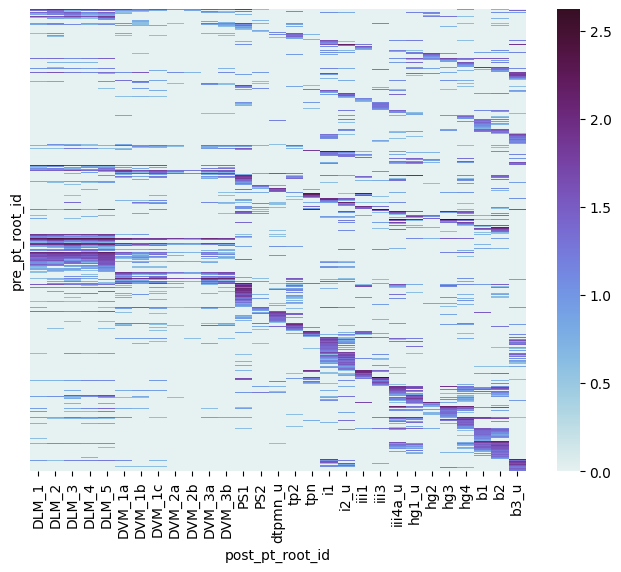

In [111]:
# check that matrix looks normal
fig = plt.figure(1, figsize = [8,6])
cmap = cmocean.cm.dense
df = MNpreMN_ordered_adj.iloc[:,:-1]
log_df = np.log10(df +1)
ax = sns.heatmap(log_df, cmap = cmap, yticklabels = '')
# plt.savefig('wing_connmat1206.eps', format='eps', bbox_inches='tight')

plt.show()

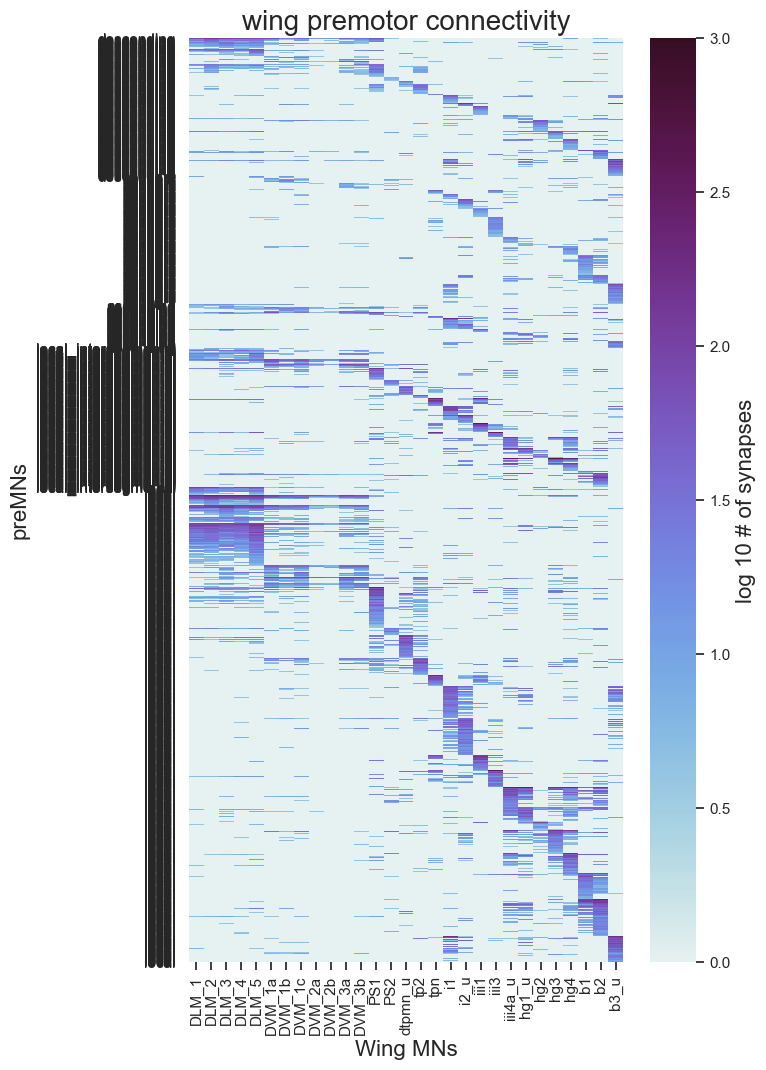

In [87]:
# plotting code for wing premotor connectome
source = MNpreMN_ordered_adj.iloc[:,:-1]

fig = plt.figure(1, figsize = [7,12])
sns.set(font_scale= 1)
cmap = cmocean.cm.dense

log_values = np.log10(source +1)
pmn_ids = sorted_df.classification_system
mn_ids = source.columns.to_list()
ax = sns.heatmap(log_values, vmin = 0, vmax = 3, xticklabels=mn_ids, yticklabels=pmn_ids, cmap = cmap)

ax.xaxis.set_ticks_position('bottom')
cbar = ax.collections[0].colorbar
plt.title('wing premotor connectivity', size = 20)
cbar.set_label(label = 'log 10 # of synapses', size=16)
plt.xlabel('Wing MNs', size = 16)
plt.ylabel('preMNs', size = 16)
plt.savefig('wing_connmat1121.eps', format='eps', bbox_inches='tight')

plt.show()

In [113]:
# add neurotransmitter info - only to local and intersegmental neurons
# NT lists - according to Lacin et al 2019
GABA_list = ['11B', '0A', '6A', '3B', '5B', '19A', '6B', '12B', '13B', '13A','9A','1B']
Glu_list = ['2A', '16B', '8A', '21A', '14A', '24B_'] #'15B', 
ACh_list = ['17A', '12A', '8B', '19B', '11A', '7B', '23B', '18B', '1A', '20A', '4B', '3A', '22A','10B','PSI']

sorted_df['putative_NT'] = 'unk' #unknown
sorted_df.loc[sorted_df['cell_type'].isin(ACh_list), 'putative_NT'] = 'ACh'
sorted_df.loc[sorted_df['cell_type'].isin(GABA_list), 'putative_NT'] = 'GABA'
sorted_df.loc[sorted_df['cell_type'].isin(Glu_list), 'putative_NT'] = 'Glu'

In [115]:
multi_df = sorted_df.set_index(['pre_pt_root_id','pref_mn', 'pref_module', 'cell_type', 'classification_system','putative_NT'])

In [116]:
multi_df

,,,,,,DLM_1,DLM_2,DLM_3,DLM_4,DLM_5,DVM_1a,DVM_1b,DVM_1c,DVM_2a,DVM_2b,...,iii3,iii4a_u,hg1_u,hg2,hg3,hg4,b1,b2,b3_u,MN_syn_total
pre_pt_root_id,pref_mn,pref_module,cell_type,classification_system,putative_NT,,,,,,,,,,,,,,,,,,,,,
648518346470309374,DLM_2,DLM_syn,uk_desc,descending,unk,79,117,101,88,69,67,22,40,11,12,...,0,0,0,0,0,8,0,4,0,780
648518346490882081,DLM_2,DLM_syn,uk_desc,descending,unk,20,47,25,23,28,16,4,9,0,0,...,0,0,0,0,0,0,0,0,0,225
648518346492458683,DLM_2,DLM_syn,uk_desc,descending,unk,21,45,27,22,25,16,6,8,0,0,...,0,0,0,0,0,0,0,0,0,204
648518346504153324,DLM_2,DLM_syn,uk_desc,descending,unk,25,39,22,30,27,7,0,11,0,4,...,0,0,0,0,0,0,0,0,0,196
648518346486616781,DLM_2,DLM_syn,uk_desc,descending,unk,21,26,5,14,21,8,9,5,0,6,...,0,0,0,0,0,0,0,0,26,141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648518346496670722,b3_u,steerB_syn,19B,local,ACh,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,17,17
648518346480611805,b3_u,steerB_syn,6A,local,GABA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,16,16
648518346465907504,b3_u,steerB_syn,6A,local,GABA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,13


In [117]:
multi_df.to_pickle("./preMN_to_MN_wing_011524.pkl")

In [118]:
# also export synapse dataframe with pt positions
df = full_df[full_df.pre_pt_root_id.isin(syn_df_premotor.pre_pt_root_id.to_list())]

In [119]:
df2 = df[['pre_pt_root_id','post_pt_root_id','pre_pt_position','post_pt_position']]

In [120]:
df2.to_pickle('syanpse_positions_wing_011524.pkl')

In [121]:
df2

,pre_pt_root_id,post_pt_root_id,pre_pt_position,post_pt_position
1,648518346481006938,648518346493247552,"[23027, 124385, 1028]","[23007, 124409, 1029]"
2,648518346481006938,648518346493247552,"[23045, 124407, 1025]","[23029, 124447, 1025]"
3,648518346481006938,648518346471876251,"[23069, 124559, 993]","[23029, 124571, 994]"
4,648518346481006938,648518346471876251,"[23027, 124591, 967]","[23043, 124563, 969]"
10,648518346467079918,648518346494250631,"[33603, 124167, 950]","[33585, 124181, 949]"
...,...,...,...,...
177650,648518346491962898,648518346486682876,"[27333, 119677, 923]","[27367, 119653, 924]"
177651,648518346494445170,648518346515574010,"[25011, 143183, 1114]","[24981, 143155, 1115]"
177652,648518346485390355,648518346482131604,"[25017, 142429, 1116]","[24987, 142405, 1116]"
177653,648518346494445170,648518346515574010,"[25001, 142471, 1121]","[24985, 142443, 1121]"
